# Naive Bayes

## Librerias a utilizar

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import joblib
from sklearn.feature_extraction.text import CountVectorizer
import unicodedata
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from imblearn.under_sampling import RandomUnderSampler

In [95]:
data_n=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv')

In [96]:
data_n.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


### Paso 1. Preparar la data del modelo a utilizar

- Creo una copia de la columna 'review' pero eliminando cualquier espacio en blanco al principio y final del string y lo transformo todo en minúscula

- Se crea un data_set solo con la caracteristica review_c y el target polarity


In [97]:
data_n["review_c"] = data_n["review"].str.strip().str.lower()

In [98]:
data_n.head()

,package_name,review,polarity,review_c
0,com.facebook.katana,privacy at least put some option appear offli...,0,privacy at least put some option appear offlin...
1,com.facebook.katana,"messenger issues ever since the last update, ...",0,"messenger issues ever since the last update, i..."
2,com.facebook.katana,profile any time my wife or anybody has more ...,0,profile any time my wife or anybody has more t...
3,com.facebook.katana,the new features suck for those of us who don...,0,the new features suck for those of us who don'...
4,com.facebook.katana,forced reload on uploading pic on replying co...,0,forced reload on uploading pic on replying com...


In [99]:
var=['review_c','polarity']
data_f=data_n[var]
data_f.head()

,review_c,polarity
0,privacy at least put some option appear offlin...,0
1,"messenger issues ever since the last update, i...",0
2,profile any time my wife or anybody has more t...,0
3,the new features suck for those of us who don'...,0
4,forced reload on uploading pic on replying com...,0


<Axes: xlabel='polarity', ylabel='Count'>

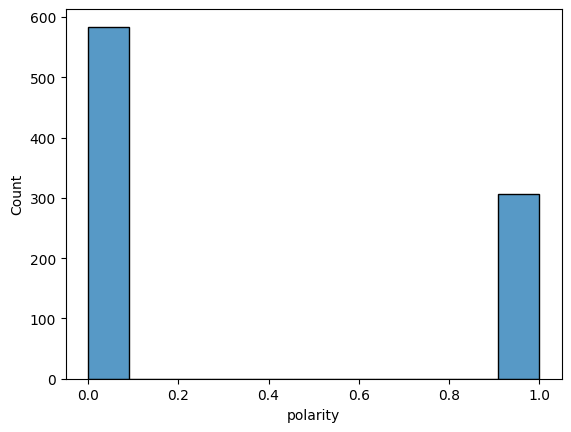

In [100]:
sns.histplot(data=data_f, x='polarity')

### Revisar el desbalanceo del target, lo mas correcto es reducir la clase mayoritaria.

In [101]:
data_f.shape

(891, 2)

In [102]:
X=data_f['review_c']
y=data_f['polarity']

In [103]:
X.iloc[118,]

'totally diferent from the web page do not use this app, use the web page instead, you will be able to do much more from there. it is almost impossible to apply to a job from here.'

### Paso 2. Dividir el conjunto de datos en train y test: X_train, X_test, y_train, y_test

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


### Paso 3. Transformar el texto en una matriz de recuento de palabras.

- Se crea una funcion para normalizar el texto, usando la libreria unicodedata.normalize('NFKD', text), es una forma de preprocesar el texto, eliminando acentos y otros signos diacríticos.

- Posteriormente con el objeto CountVectorizer se reprocesa X_train y X_test, en arreglos de recuento de palabras para ser usadas mas adelante en el modelo a definir. 

In [105]:
def normalize_text(text):
    return unicodedata.normalize('NFKD', text)

In [106]:

vec_model = CountVectorizer(stop_words = "english", preprocessor=normalize_text)
X_train_p = vec_model.fit_transform(X_train).toarray()
X_test_p = vec_model.transform(X_test).toarray()


In [107]:
vec_model

CountVectorizer(preprocessor=<function normalize_text at 0x000001F5531F07C0>,
                stop_words='english')

**Impresión del vocabulario generado en el vec_model**

In [108]:
print(vec_model.vocabulary_)

{'just': 1550, 'did': 822, 'latest': 1611, 'update': 3071, 'viber': 3129, 'problems': 2208, 'send': 2539, 'messages': 1801, 'try': 2995, 'make': 1741, 'saying': 2491, 'ringing': 2431, 'sound': 2685, 'don': 874, 'think': 2915, 'actually': 105, 'answers': 187, 'calls': 454, 'time': 2937, 'updates': 3075, 'doesn': 869, 'work': 3235, 'fix': 1113, 'asap': 236, 'england': 971, 'thank': 2901, 'keeps': 1556, 'crashing': 706, 'works': 3238, 'extreme': 1045, 'data': 750, 'savings': 2488, 'mode': 1839, 'high': 1361, 'websites': 3187, 'dont': 877, 'load': 1676, 'moving': 1857, 'browser': 411, 'fail': 1058, 'boat': 368, 'arrived': 231, 'version': 3125, 'touted': 2968, 'advanced': 129, 'fact': 1056, 'contains': 664, 'big': 339, 'old': 1977, 'disappointment': 847, 'widget': 3209, 'wasn': 3172, 'available': 269, 'google': 1245, 'urged': 3090, 'switch': 2831, 'sms': 2652, 'function': 1187, 'hangouts': 1309, 'longer': 1693, 'wth': 3256, 'want': 3167, 'use': 3095, 'app': 199, 'messaging': 1802, 'quick': 

**Ejemplo: Como crear un dataframe con los datos de entrenamiento transformados y los nombres de las palabras encontradas como columnas y no indices**

In [109]:
df_train_p = pd.DataFrame(X_train_p, columns=vec_model.vocabulary_.keys())

In [110]:
df_train_p.head()

,just,did,latest,update,viber,problems,send,messages,try,make,...,unlimited,loving,breaks,header,agreed,merged,engineering,update2,11,update3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Ejemplo: Como aplicar el método .inverse_transform para encontrar a partir del indice el mensaje original**

In [111]:
doc_vector = X_train_p[277]
doc_vector = doc_vector.reshape(1, -1) # Para transformar el arreglo de 1 dimensión a 2 dimensiones
original_text = vec_model.inverse_transform(doc_vector)
print(original_text)


[array(['como', 'compartir', 'conseguido', 'contactos', 'desinstalando',
       'directamente', 'esta', 'funcia', 'han', 'hecho', 'la', 'malware',
       'marshmallow', 'nose', 'nueva', 'nunca', 'puro', 'que', 'salga',
       'salgan', 'siempre', 'solo', 'te', 'telegram', 'uso', 'viva',
       'whatsapp', 'ya', 'łn'], dtype='<U24')]


### Paso 4. Selección del modelo.

Vamos a iniciar con un modelo MultinomialNB, dado las caracteristicas de la data (clasificación con características que representan conteos o frecuencias discretas)

In [112]:
model_nb = MultinomialNB()
model_nb.fit(X_train_p, y_train)

MultinomialNB()

### Paso 5. Predicciones y Rendieminto del Modelo

In [113]:
y_pred = model_nb.predict(X_test_p)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")


Accuracy Score: 0.8044692737430168


### Paso 6. Métricas de Desempeño del Modelo

#### Curva Roc

In [114]:
y_pred_proba=model_nb.predict_proba(X_test_p)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_value = auc(fpr, tpr)

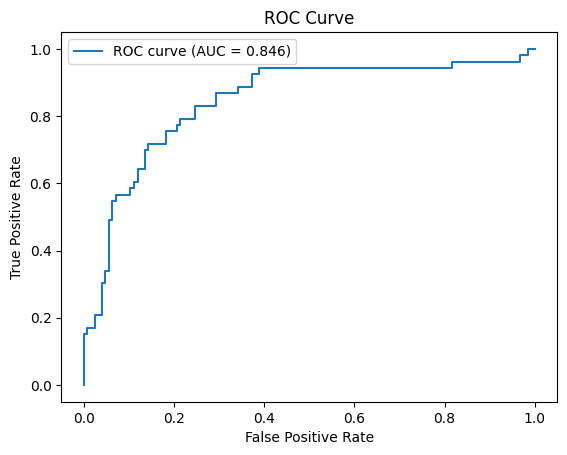

In [115]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc_value))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### Matriz de Confusión

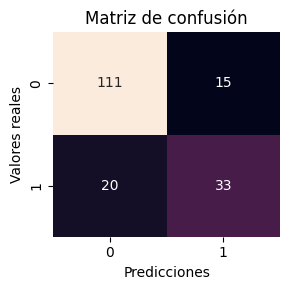

In [116]:
cm = confusion_matrix(y_test, y_pred)

# Dibujaremos esta matriz para hacerla más visual
cm_df = pd.DataFrame(cm)

plt.figure(figsize = (3, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)

plt.title('Matriz de confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')

plt.tight_layout()

plt.show()

In [117]:
print("Reporte de Clasificacion:")
print(classification_report(y_test, y_pred))

Reporte de Clasificacion:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       126
           1       0.69      0.62      0.65        53

    accuracy                           0.80       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.80      0.80      0.80       179



#### Otras métricas de rendimiento del modelo

In [118]:
# Predicciones en entrenamiento
y_pred_train = model_nb.predict(X_train_p)

# Precisión en entrenamiento
precision_train = accuracy_score(y_train, y_pred_train)

# Predicciones en evaluación
y_pred_test = model_nb.predict(X_test_p)

# Precisión en evaluación
precision_test = accuracy_score(y_test, y_pred_test)

# Gap de precisión
gap_precision = precision_train - precision_test
print('Gap de Presicion:',round(gap_precision,2))

#Coeficiente de sobreajuste
#Coeficiente de sobreajuste = (Precisión en entrenamiento - Precisión en evaluación) / Precisión en entrenamiento
#Un coeficiente cercano a 1 indica sobreajuste severo.

coeficiente_sobreajuste = gap_precision / precision_train
print('Coeficiente de sobreajuste:',round(coeficiente_sobreajuste,3))

# Ratio de sobreajuste
ratio_sobreajuste = (precision_train / precision_test) - 1
print('Ratio de Sobreajuste:',round(ratio_sobreajuste,2))



Gap de Presicion: 0.16
Coeficiente de sobreajuste: 0.163
Ratio de Sobreajuste: 0.19


In [119]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient:", mcc)

Matthews Correlation Coefficient: 0.5189761422482239


## Modelo con Data Balanceada. Aplicaremos Undersampling la clase mayoritaria

In [120]:
data_f.head()

,review_c,polarity
0,privacy at least put some option appear offlin...,0
1,"messenger issues ever since the last update, i...",0
2,profile any time my wife or anybody has more t...,0
3,the new features suck for those of us who don'...,0
4,forced reload on uploading pic on replying com...,0


In [121]:
X=pd.DataFrame(X)
y=pd.DataFrame(y)
rus = RandomUnderSampler(random_state=42)
X_bal, y_bal = rus.fit_resample(X,y)
data_bal=pd.concat([X_bal, y_bal], axis=1)
data_bal = data_bal.reset_index(drop=True)
data_bal.head()
Xb=data_bal['review_c']
yb=data_bal['polarity']


<Axes: xlabel='polarity', ylabel='Count'>

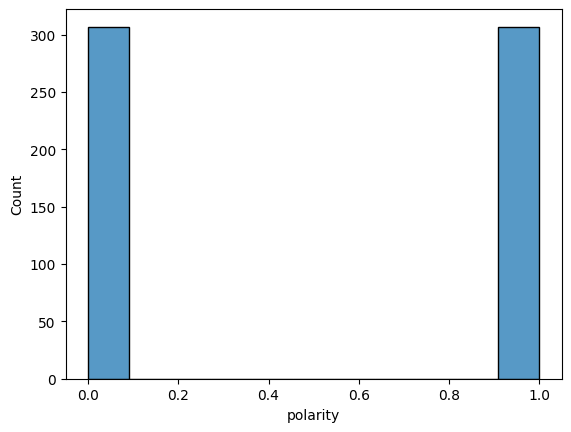

In [122]:
sns.histplot(data=data_bal, x='polarity')

### Paso 2. Dividir el conjunto de datos.

In [123]:
X_trainb, X_testb, y_trainb, y_testb = train_test_split(Xb, yb, test_size = 0.2, random_state = 42)

### Paso 3. Transformar el texto en una matriz de recuento de palabras.

In [124]:
vec_modelb = CountVectorizer(stop_words = "english", preprocessor=normalize_text)
X_train_pb = vec_modelb.fit_transform(X_trainb).toarray()
X_test_pb = vec_modelb.transform(X_testb).toarray()

### Paso 4. Seleccion Modelo

In [125]:
modelb_nb = MultinomialNB()
modelb_nb.fit(X_train_pb, y_trainb)

MultinomialNB()

### Predicciones y Rendimiento Modelo

In [126]:
y_predb = modelb_nb.predict(X_test_pb)
print(f"Accuracy Score: {accuracy_score(y_testb, y_predb)}")

Accuracy Score: 0.7317073170731707


### Paso 6. Métricas de Desempeño del Modelo

#### Curva ROC

In [127]:
y_pred_proba=modelb_nb.predict_proba(X_test_pb)[:, 1]
fprb, tprb, _ = roc_curve(y_testb, y_pred_proba)
auc_value = auc(fprb, tprb)

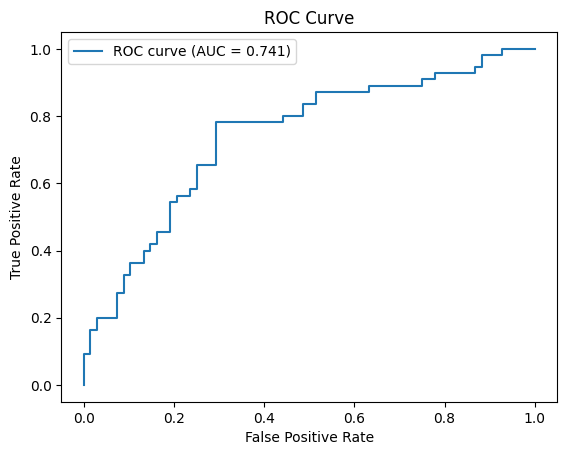

In [128]:
# Plot the ROC curve
plt.plot(fprb, tprb, label='ROC curve (AUC = {:.3f})'.format(auc_value))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### Matriz de Confusion

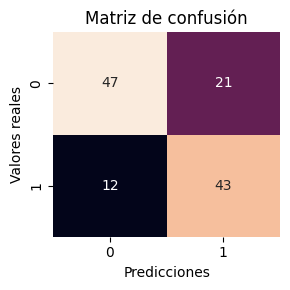

In [129]:
cm = confusion_matrix(y_testb, y_predb)

# Dibujaremos esta matriz para hacerla más visual
cm_dfb = pd.DataFrame(cm)

plt.figure(figsize = (3, 3))
sns.heatmap(cm_dfb, annot=True, fmt="d", cbar=False)

plt.title('Matriz de confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')

plt.tight_layout()

plt.show()

In [130]:
print("Reporte de Clasificacion:")
print(classification_report(y_testb, y_predb))

Reporte de Clasificacion:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74        68
           1       0.67      0.78      0.72        55

    accuracy                           0.73       123
   macro avg       0.73      0.74      0.73       123
weighted avg       0.74      0.73      0.73       123



#### Otras metricas de rendimiento

In [131]:
# Predicciones en entrenamiento
y_pred_trainb = modelb_nb.predict(X_train_pb)

# Precisión en entrenamiento
precision_trainb = accuracy_score(y_trainb, y_pred_trainb)

# Predicciones en evaluación
y_pred_testb = modelb_nb.predict(X_test_pb)

# Precisión en evaluación
precision_testb = accuracy_score(y_testb, y_pred_testb)

# Gap de precisión
gap_precisionb = precision_trainb - precision_testb
print('Gap de Presicion:',round(gap_precisionb,2))

#Coeficiente de sobreajuste
#Coeficiente de sobreajuste = (Precisión en entrenamiento - Precisión en evaluación) / Precisión en entrenamiento
#Un coeficiente cercano a 1 indica sobreajuste severo.

coeficiente_sobreajusteb = gap_precisionb / precision_trainb
print('Coeficiente de sobreajuste:',round(coeficiente_sobreajusteb,3))

# Ratio de sobreajuste
ratio_sobreajusteb = (precision_trainb / precision_testb) - 1
print('Ratio de Sobreajuste:',round(ratio_sobreajusteb,2))


Gap de Presicion: 0.25
Coeficiente de sobreajuste: 0.253
Ratio de Sobreajuste: 0.34


### Observaciones Desbalanceo Vs. Balanceo

- Podemos comentar que el modelo con los datos desbalanceados ajusta mejor a los datos de evaluación, las métricas apoyan esta aseveración. Para la data balanceada el Gap de Presición, coeficiente y ratio de sobreajuste, son superiores a los datos balanceaados, incluso el accuracy de este último es superior.

- Quizás el RandomUnderSampler no fue el más ideal para resolver el desbalanceo. Existen técnicas como asignacaión de pesos a las clases para que el modelo tenga en cuenta la importancia relativa de cada clase.

- En lo siguiente vamos a tratar de optimizar el modelo original.

### Paso 7. Optimizacion del modelo original con data desbalanceada

#### RandomizedSearchCV

In [132]:

parametros = {
    'alpha': [0.1, 1, 10],
    'force_alpha': [True, False],
    'fit_prior': [True, False]
}

model_rs = RandomizedSearchCV(MultinomialNB(), parametros, cv=5, scoring='accuracy', n_iter=10)
model_rs.fit(X_train_p, y_train)

print("Mejores parámetros:", model_rs.best_params_)
print("Mejor puntaje:", model_rs.best_score_)


Mejores parámetros: {'force_alpha': False, 'fit_prior': False, 'alpha': 1}
Mejor puntaje: 0.8159755737220525


In [133]:
model_rsf = MultinomialNB(force_alpha=False, fit_prior=False, alpha=1)
model_rsf.fit(X_train_p, y_train)

MultinomialNB(alpha=1, fit_prior=False, force_alpha=False)

In [134]:
y_pred_rs = model_rsf.predict(X_test_p)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_rs)}")

Accuracy Score: 0.8156424581005587


#### GridSearchCV

In [135]:
param_grid = {
    'alpha': [0.1, 1, 10],
    'force_alpha': [True, False],
    'fit_prior': [True, False]
}

model_gs = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=5, scoring='accuracy',verbose=1)
model_gs.fit(X_train_p, y_train)

print("Mejores parámetros:", model_gs.best_params_)
print("Mejor puntaje:", model_gs.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros: {'alpha': 1, 'fit_prior': False, 'force_alpha': True}
Mejor puntaje: 0.8159755737220525


In [136]:
model_gsf = MultinomialNB(force_alpha=True, fit_prior=False, alpha=1)
model_gsf.fit(X_train_p, y_train)

MultinomialNB(alpha=1, fit_prior=False)

In [137]:
y_pred_gs = model_gsf.predict(X_test_p)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_gs)}")

Accuracy Score: 0.8156424581005587


Se puede trabajar con los cualquiera de los modelos generados por RandomizedSearch y GridSearh, el accuracy es el mismo, mejoro en relacion al modelo original con los parametros por defecto.

Vamos a tratar de modelar esta data con las otras dos funciones de Naive Bayes para ver los resultados; es decir, GaussianNB y BernoulliNB

#### Aplicando otros modelos
##### GaussianNB

In [138]:
model_gaus = GaussianNB()
model_gaus.fit(X_train_p, y_train)

GaussianNB()

In [139]:
y_pred_gaus = model_gaus.predict(X_test_p)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_gaus)}")

Accuracy Score: 0.8044692737430168


##### BernoulliNB

In [140]:
model_bern = BernoulliNB()
model_bern.fit(X_train_p, y_train)

BernoulliNB()

In [141]:
y_pred_bern = model_bern.predict(X_test_p)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_bern)}")

Accuracy Score: 0.776536312849162


##### Los resultados obtenidos con la funcion multinomialNB y GaussianNB son muy parecidas, quizas la distribucion de las caracteriticas pueden ajustarse a ambas distribuciones. Se podria obtener con pruebas estadisticas que porcentaje de las mismas obedecen a una u otra distribucion, voy a intentar hacerlo en lo subsigueinte.

##### Funcion para determinar como se ajustan las 3291 caracteristicas a las curvas normal y multinomial

In [142]:
from scipy.stats import shapiro, chisquare
def test_distributions(X, alpha=0.05):
    """
    Testea la distribución de cada característica en X.

    Parámetros:
    - X: matriz de características (n_samples, n_features)
    - alpha: umbral de significación (default=0.05)

    Retorna:
    - normality_results: diccionario con resultados de tests de normalidad
    - multinomiality_results: diccionario con resultados de tests de multinomialidad
    """
    
    n_features = X.shape[1]
    normality_results = {}
    multinomiality_results = {}
    
    for i in range(n_features):
        feature = X[:, i]
        # Test de normalidad
        stat_shapiro, p_shapiro = shapiro(feature)
        normality_results[f"Feature {i+1}"] = {"Shapiro-Wilk": (stat_shapiro, p_shapiro)}
        
        # Test de multinomialidad
        observed_freqs = X[:, i]
        observed_sum = observed_freqs.sum()
        expected_freqs = [observed_sum / len(X)] * len(X)
        stat_chi2, p_chi2 = chisquare(observed_freqs, f_exp=expected_freqs)
        multinomiality_results[f"Feature {i+1}"] = {"Chi-Squared": (stat_chi2, p_chi2)}
        
    return normality_results, multinomiality_results

##### Calculo del porcentaje de las caracteristicas que se ajustan a la normal y a la multinomial

In [143]:
normality_results, multinomiality_results = test_distributions(X_train_p, 0.05)

normal_features = [feature for feature, result in normality_results.items() if result["Shapiro-Wilk"][1] > 0.05]
multinomial_features = [feature for feature, result in multinomiality_results.items() if result['Chi-Squared'][1] > 0.05]

num_features = X_train_p.shape[1]

normal_percentage = len(normal_features) / num_features* 100
multinomial_percentage = len(multinomial_features) / num_features* 100

print(f"Porcentaje de características que siguen una distribución normal: {normal_percentage:.2f}%")
print(f"Porcentaje de características que siguen una distribución multinomial: {multinomial_percentage:.2f}%")

Porcentaje de características que siguen una distribución normal: 0.00%
Porcentaje de características que siguen una distribución multinomial: 82.56%


#### Hallazgos

- Casi el 83% de las características se ajustan a la distribucion multinomial.
- Ninguna característica se ajusta a la curva normal.
    - Una de las explicaciones puede ser que el modelo GaussianNB es relativamente robusto a violaciones de la suposición de normalidad. Aunque la teoría detrás del modelo asume que las características siguen una distribución normal, en la práctica, el modelo puede funcionar bien incluso cuando las características no siguen una distribución normal exacta.
    - El modelo GaussianNB utiliza aproximaciones para calcular las probabilidades. Estas aproximaciones pueden ser lo suficientemente buenas como para producir resultados precisos, incluso cuando las características no siguen una distribución normal.
    - Se tendria que investigar más al respecto, este resultado es muy contradictorio. 

## Guardando el modelo

In [144]:
joblib.dump(model_gsf, '../../Naive_Bayes/models/navie_bayes_model_gsf.joblib')

['../../Naive_Bayes/models/navie_bayes_model_gsf.joblib']